![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings/1.4.Handwritten_Text_Recognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

In [20]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [3]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [4]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [5]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

14:50:03, INFO SparkConf Configured, Starting to listen on port: 61738
14:50:03, INFO 61738
14:50:04, INFO Adding jar from /Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkmonitor/listener_2.12.jar 


Spark version: 3.0.2
Spark NLP version: 3.4.4
Spark OCR version: 3.14.0



14:51:41, INFO Client Connected ('127.0.0.1', 58819)


## Read image

In [21]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/Fix_handwritten_notebook/jupyter/data/handwritten/handwritten_example.jpg


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/tutorials/Certification_Trainings/handwritten_example.jpg
    Resolution: 72 dpi
    Width: 2300 px
    Height: 1725 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


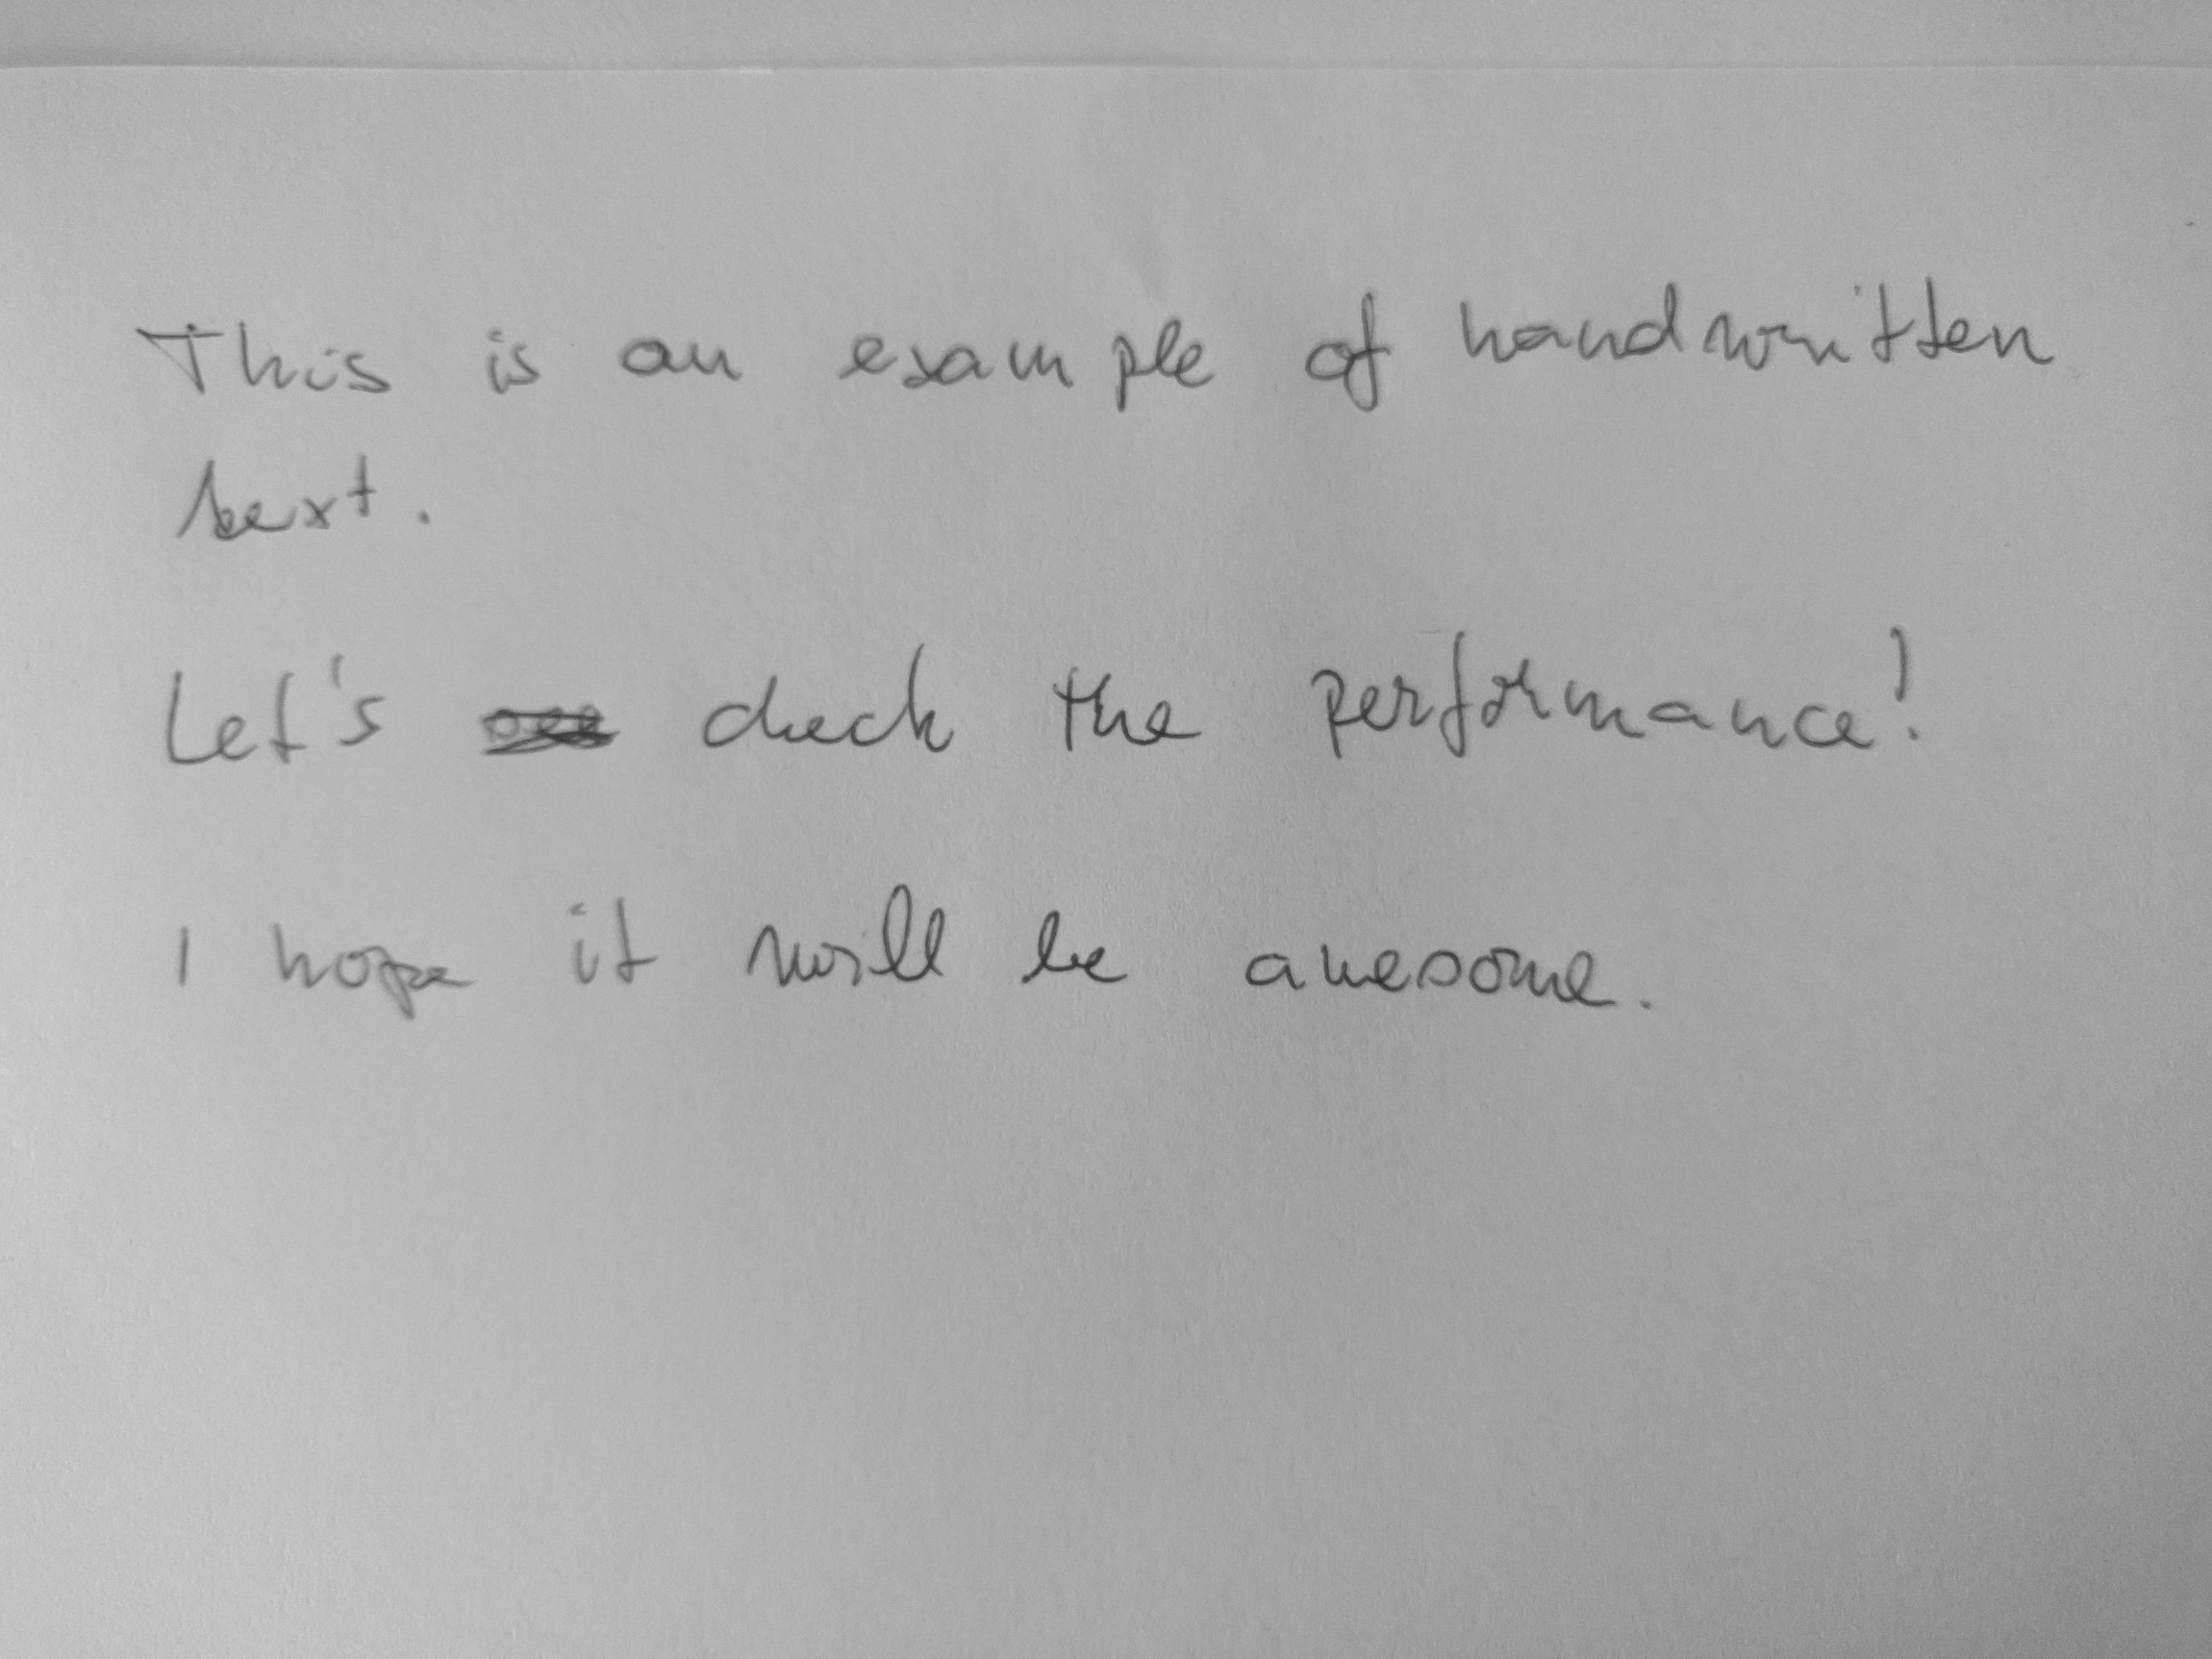

In [42]:
image_example_df = spark.read.format("binaryFile").load("handwritten_example.jpg")
image_df = BinaryToImage().transform(image_example_df).cache()

display_images(image_df)

In [43]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True) \
    .setSizeThreshold(10) \
    .setScoreThreshold(0.2) \
    .setTextThreshold(0.2) \
    .setLinkThreshold(0.3) \
    .setWidth(500)

ocr = ImageToTextV2.pretrained("ocr_base_handwritten", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setGroupImages(True) \
    .setOutputCol("text")

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_base_handwritten download started this may take some time.
Approximate size to download 745.7 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/tutorials/Certification_Trainings/handwritten_example.jpg
    Resolution: 0 dpi
    Width: 2300 px
    Height: 1725 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


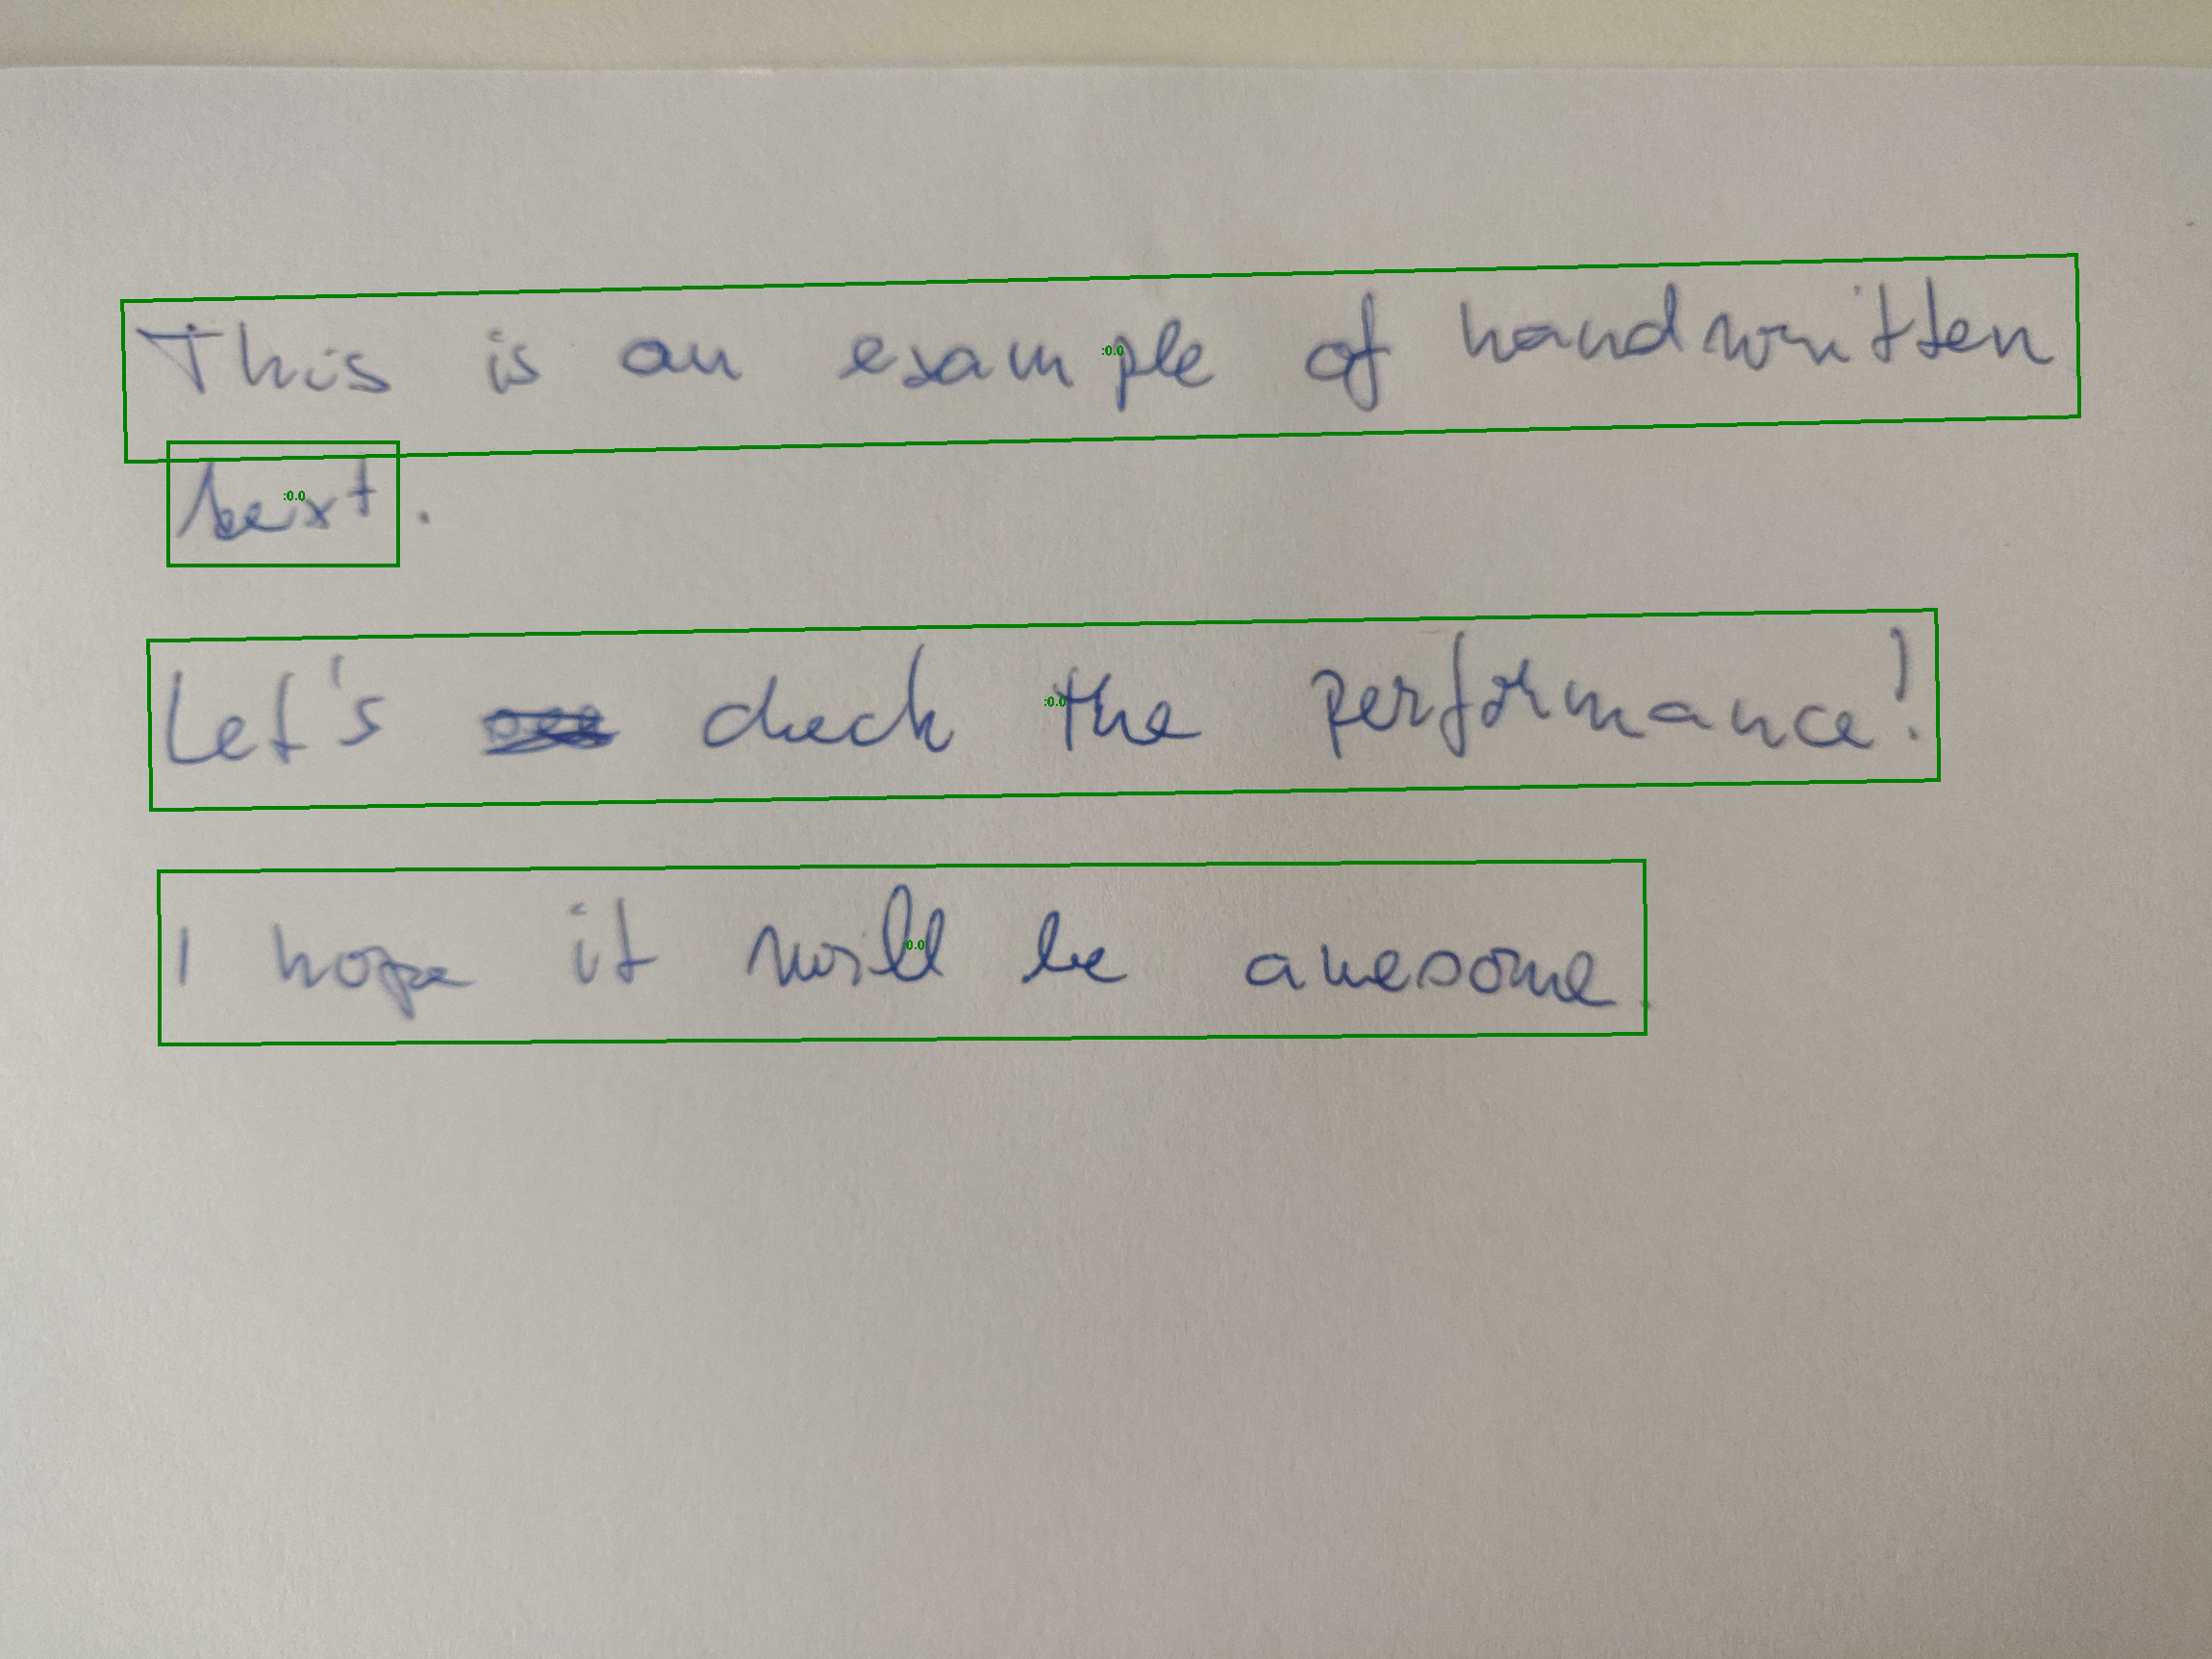

This is an example of handwritten
bext
Let's # check the performance?
I hope it will be awesome.


In [44]:
result = pipeline.transform(image_example_df).cache()
display_images(result, "image_with_regions")
print(("").join([x.text for x in result.select("text").collect()]))